In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.1.0


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [5]:
from tensorflow.keras.layers import Dense, Conv2DTranspose, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.layers import Reshape, Activation, LeakyReLU, MaxPool2D, Flatten

In [6]:
encoding_size = 100

generator = tf.keras.models.Sequential([
    Dense(7*7*128, input_shape=[encoding_size]),
    Reshape([7,7,128]),
    BatchNormalization(),
    Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu"),
    BatchNormalization(),
    Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation="tanh")
])

In [7]:
discriminator = tf.keras.models.Sequential([
    Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=tf.keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
    Dropout(0.4),
    Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=tf.keras.layers.LeakyReLU(0.2)),
    Dropout(0.4),
    Flatten(),
    Dense(1, activation="sigmoid")
])

In [8]:
dcgan = tf.keras.models.Sequential([generator, discriminator])

In [9]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
dcgan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_train = X_train_full.reshape(-1, 28, 28, 1) * 2. - 1.

batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [11]:
def train_dcgan(dcgan, datatset, batch_size=32, num_encodings=100, epochs=10):
    for epoch in range(epochs):
        print(f'Epoch: {epoch+1}/{epochs}')
        for X_batch in dataset:
            # Train the Discriminator
            latent_space = tf.random.normal([batch_size, num_encodings])
            generated_images = generator(latent_space)
            input_to_discriminator = tf.concat([generated_images, X_batch], axis=0)
            labels_to_discriminator = tf.constant([[0]] * batch_size + [[1]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(input_to_discriminator, labels_to_discriminator)
            
            # Train the Generator
            latent_space = tf.random.normal([batch_size, num_encodings])
            labels_to_dcgan = tf.constant([[1]] * batch_size)
            discriminator.trainable = False
            dcgan.train_on_batch(latent_space, labels_to_dcgan)

        plot_multiple_images(generated_images, 8)
        plt.show()

Epoch: 1/5


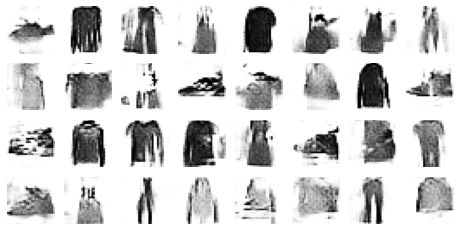

Epoch: 2/5


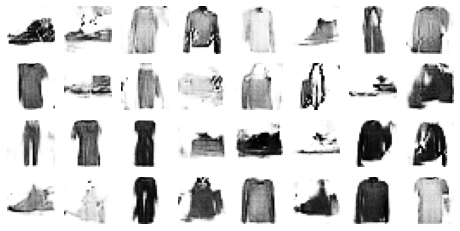

Epoch: 3/5


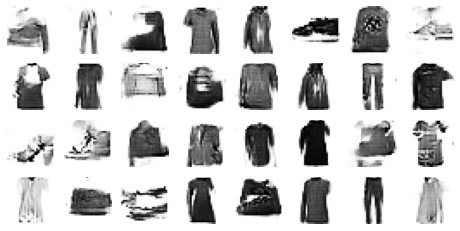

Epoch: 4/5


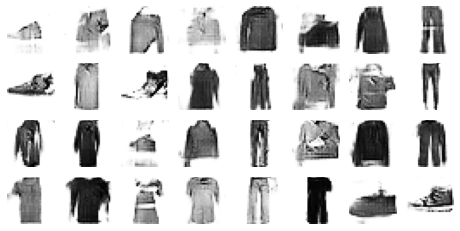

Epoch: 5/5


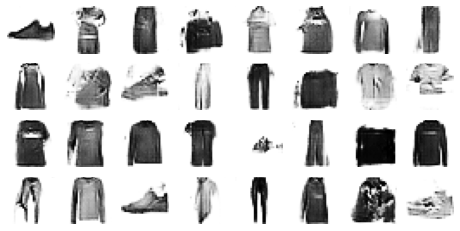

In [12]:
train_dcgan(dcgan, dataset, 32, 100, 5)

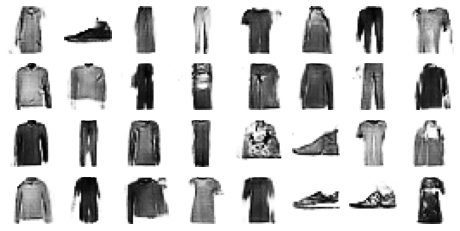

In [14]:
noise = tf.random.normal(shape=[batch_size, encoding_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
plt.savefig("dcgan_images_plot", tight_layout=False)